In [2]:
import os
import sys
import shutil
import argparse
import math
import IPython 
from PIL import Image
from enum import Enum
from typing import Callable, List, Optional, Tuple, Union
from functools import partial

import logging
import torch
import torch.nn as nn
import torchio as tio
import torchvision
from torchvision.datasets import VisionDataset
from torchvision.transforms import transforms
import numpy as np
import pandas as pd
import skimage
from scipy import sparse
import matplotlib.pyplot as plt 
import torchxrayvision as xrv
import nibabel as nib

from fvcore.common.checkpoint import Checkpointer, PeriodicCheckpointer
import dinov2.distributed as distributed
from dinov2.models.unet import UNet
from dinov2.data import SamplerType, make_data_loader, make_dataset
from dinov2.data.datasets import NIHChestXray, MC, Shenzhen, SARSCoV2CT, BTCV
from dinov2.data.datasets.medical_dataset import MedicalVisionDataset
from dinov2.data.loaders import make_data_loader
from dinov2.data.transforms import (make_segmentation_train_transforms, make_classification_eval_transform, make_segmentation_eval_transforms,
                                    make_classification_train_transform)
from dinov2.eval.setup import setup_and_build_model
from dinov2.eval.utils import (is_zero_matrix, ModelWithIntermediateLayers, ModelWithNormalize, evaluate, extract_features, collate_fn_3d,
                               make_datasets)
from dinov2.eval.classification.utils import LinearClassifier, create_linear_input, setup_linear_classifiers, AllClassifiers
from dinov2.eval.metrics import build_segmentation_metrics
from dinov2.eval.segmentation.utils import LinearDecoder, setup_decoders, DINOV2Encoder
from dinov2.utils import show_image_from_tensor

/home/user/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# args = argparse.Namespace(config_file='dinov2/configs/eval/vits14_pretrain.yaml', pretrained_weights='models/dinov2_vits14_pretrain.pth', output_dir='results/NIH/dinov2_vits14/knn', opts=[], train_dataset_str='NIHChestXray:split=TRAIN:root=/mnt/d/data/NIH', val_dataset_str='NIHChestXray:split=VAL:root=/mnt/d/data/NIH', test_dataset_str='NIHChestXray:split=TEST:root=/mnt/d/data/NIH', nb_knn=[5, 20, 50, 100, 200], temperature=0.07, gather_on_cpu=False, batch_size=8, n_per_class_list=[-1], n_tries=1, ngpus=1, nodes=1, timeout=2800, partition='learnlab', use_volta32=False, comment='', exclude='')
args = argparse.Namespace(config_file='dinov2/configs/eval/vits14_pretrain.yaml', pretrained_weights='models/dinov2_vits14_pretrain.pth', output_dir='results/NIH/dinov2_vits14/knn', opts=[], train_dataset_str='MC:split=TRAIN:root=/mnt/z/data/MC', val_dataset_str='MC:split=VAL:root=/mnt/z/data/MC', test_dataset_str='MC:split=TEST:root=/mnt/z/data/MC', nb_knn=[5, 20, 50, 100, 200], temperature=0.07, gather_on_cpu=False, batch_size=8, n_per_class_list=[-1], n_tries=1, ngpus=1, nodes=1, timeout=2800, partition='learnlab', use_volta32=False, comment='', exclude='')
# args = argparse.Namespace(config_file='dinov2/configs/eval/vits14_pretrain.yaml', pretrained_weights='models/dinov2_vits14_pretrain.pth', output_dir='results/NIH/dinov2_vits14/knn', opts=[], train_dataset_str='BTCV:split=TRAIN:root=/mnt/z/data/BTCV', val_dataset_str='BTCV:split=VAL:root=/mnt/z/data/BTCV', test_dataset_str='BTCV:split=TEST:root=/mnt/z/data/BTCV', nb_knn=[5, 20, 50, 100, 200], temperature=0.07, gather_on_cpu=False, batch_size=8, n_per_class_list=[-1], n_tries=1, ngpus=1, nodes=1, timeout=2800, partition='learnlab', use_volta32=False, comment='', exclude='')
model, autocast_dtype = setup_and_build_model(args)
autocast_ctx = partial(torch.cuda.amp.autocast, enabled=True, dtype=autocast_dtype)
# feature_model_with_inter = ModelWithIntermediateLayers(model, 4, autocast_ctx, is_3d=False)
# model = ModelWithNormalize(model)

I20231008 18:19:02 623 dinov2 config.py:60] git:
  sha: c84b9711af7d5c040597e989149bbd2f4d43eab6, status: has uncommitted changes, branch: main

I20231008 18:19:02 623 dinov2 config.py:61] batch_size: 8
comment: 
config_file: dinov2/configs/eval/vits14_pretrain.yaml
exclude: 
gather_on_cpu: False
n_per_class_list: [-1]
n_tries: 1
nb_knn: [5, 20, 50, 100, 200]
ngpus: 1
nodes: 1
opts: ['train.output_dir=/mnt/c/Users/user/Desktop/dinov2/results/NIH/dinov2_vits14/knn']
output_dir: /mnt/c/Users/user/Desktop/dinov2/results/NIH/dinov2_vits14/knn
partition: learnlab
pretrained_weights: models/dinov2_vits14_pretrain.pth
temperature: 0.07
test_dataset_str: MC:split=TEST:root=/mnt/z/data/MC
timeout: 2800
train_dataset_str: MC:split=TRAIN:root=/mnt/z/data/MC
use_volta32: False
val_dataset_str: MC:split=VAL:root=/mnt/z/data/MC
I20231008 18:19:02 623 dinov2 config.py:27] sqrt scaling learning rate; base: 0.004, new: 0.001
I20231008 18:19:02 623 dinov2 config.py:34] MODEL:
  WEIGHTS: ''
compute_preci

In [1]:
class _Split(Enum):
    TRAIN = "train"
    VAL = "val"
    TEST = "test"

    @property
    def length(self) -> int:
        split_lengths = {
            _Split.TRAIN: 15,
            _Split.VAL: 15,
            _Split.TEST: 20,
        }
        return split_lengths[self]


class BTCV(MedicalVisionDataset):
    Split = _Split

    def __init__(
        self,
        *,
        split: "BTCV.Split",
        root: str,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(split, root, transforms, transform, target_transform)

        self._image_path = self._split_dir + os.sep + "img"
        self.images = np.array(os.listdir(self._image_path))

        self.labels = None
        if self._split != _Split.TEST:
            self._labels_path = self._split_dir + os.sep + "label"
            self.labels = np.array(os.listdir(self._labels_path))
    
        self.class_id_mapping = pd.DataFrame([i for i in range(14)],
                                    index=["background", "spleen", "rkid", "lkid", "gall", "eso",
                                           "liver", "sto", "aorta", "IVC", "veins", "pancreas",
                                           "rad", "lad"],
                                    columns=["class_id"])
        self.class_names = np.array(self.class_id_mapping.index)

    def _check_size(self):
        num_of_images = len(os.listdir(self._split_dir + os.sep + "img"))
        logging.info(f"{self._split.length - num_of_images} scans are missing from {self._split.value.upper()} set")

    def get_num_classes(self) -> int:
        return len(self.class_names)

    def is_3d(self) -> bool:
        return True

    def get_image_data(self, index: int, return_affine_matrix=False) -> np.ndarray:
        image_folder_path = self._image_path + os.sep + self.images[index]
        image_path = image_folder_path + os.sep + os.listdir(image_folder_path)[0]  

        if self._split == _Split.TRAIN:
            nifti_image = nib.load(image_path, mmap=False)
            proxy = nifti_image.dataobj
            slice_indices = proxy.shape[-1] - 1
            start = np.random.randint(0, slice_indices-10)
            indices = list(range(start, start+10))
            image = np.array([proxy[..., i] for i in indices])
        else:
            nifti_image = nib.load(image_path)
            image = nifti_image.get_fdata()
            image = image.transpose(2, 0, 1)

        image = np.stack((image,)*3, axis=0)
        image = torch.from_numpy(image).permute(1, 0, 2, 3).float()

        if return_affine_matrix:
            affine = nifti_image.affine
            return image, affine
        
        # pre-preprocess
        image = torch.clamp(image, max=1024)
        return image
    
    def get_target(self, index: int) -> Tuple[np.ndarray, torch.Tensor, None]:
        if self.split == _Split.TEST:
            return None

        label_folder_path = self._labels_path + os.sep + self.labels[index]
        label_path = label_folder_path + os.sep + os.listdir(label_folder_path)[0]  

        if self._split == _Split.TRAIN:
            nifti_image = nib.load(label_path, mmap=False)
            proxy = nifti_image.dataobj
            slice_indices = proxy.shape[-1] - 1
            start = np.random.randint(0, slice_indices-10)
            indices = list(range(start, start+10))
            target = np.array([proxy[..., i] for i in indices])
        else:
            target = nib.load(label_path).get_fdata()
            target = target.transpose(2, 0, 1)
        
        target = torch.from_numpy(target).unsqueeze(0).long()
        target = target.permute(1, 0, 2, 3)
    
        return target
    
    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int):

        image = self.get_image_data(index)
        target = self.get_target(index)

        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        if self.transform is not None:
            transformed_image = []
            for i in range(len(image)):
                np.random.seed(seed), torch.manual_seed(seed) 
                transformed_image.append(self.transform(image[i]))
            image = torch.stack(transformed_image, dim=0).squeeze()

        if self.target_transform is not None and target is not None:
            transformed_target = []
            for i in range(len(target)):
                np.random.seed(seed), torch.manual_seed(seed) 
                transformed_target.append(self.target_transform(target[i]))
            target = torch.stack(transformed_target, dim=0).squeeze()

        return image, target

NameError: name 'Enum' is not defined

In [7]:
train_image_transform, train_target_transform = make_segmentation_train_transforms(resize_size=224)
eval_image_transform, eval_target_transform  = make_segmentation_eval_transforms(resize_size=224)
images = BTCV(root="/mnt/z/data/BTCV/", split=_Split.TRAIN, transform=eval_image_transform, target_transform=eval_target_transform)

I20231008 18:20:06 623 root 2248798430.py:47] 0 scans are missing from TRAIN set


after transform torch.Size([10, 3, 224, 224])
torch.Size([10, 3, 224, 224])
[0 1 5 6 7 8 9]
tensor(9)


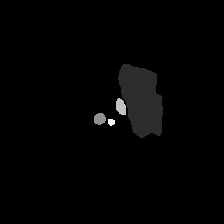

14


In [17]:
for i, t in images:
    print(i.shape)
    print(np.unique(t))
    print(t.max())
    show_image_from_tensor(t[6].unsqueeze(0) * 50 )
    print(images.get_num_classes())
    break

In [79]:
train_image_transform, train_target_transform = make_segmentation_train_transforms(resize_size=224)
eval_image_transform, eval_target_transform  = make_segmentation_eval_transforms(resize_size=224)
# train_image_transform = make_classification_train_transform()
# eval_image_transform = make_classification_eval_transform()

# train_target_transform = eval_target_transform = None

# val_dataset_str = args.val_dataset_str
val_dataset_str = None

train_dataset, val_dataset, test_dataset = make_datasets(train_dataset_str=args.train_dataset_str, val_dataset_str=val_dataset_str,
                                                        test_dataset_str=args.test_dataset_str, train_transform=train_image_transform,
                                                        eval_transform=eval_image_transform, train_target_transform=train_target_transform,
                                                        eval_target_transform=eval_target_transform)

# sampler_type = SamplerType.INFINITE
sampler_type = None

is_3d = test_dataset.is_3d()

# train_data_loader = make_data_loader(
#     dataset=train_dataset,
#     batch_size=2,
#     num_workers=0,
#     shuffle=True,
#     seed=0,
#     sampler_type=sampler_type,
#     sampler_advance=0,
#     drop_last=False,
#     persistent_workers=False,
#     collate_fn=collate_fn_3d if is_3d else None
# )

train_data_loader = make_data_loader(
    dataset=images,
    batch_size=2,
    num_workers=0,
    shuffle=True,
    seed=0,
    sampler_type=sampler_type,
    sampler_advance=0,
    drop_last=False,
    persistent_workers=False,
    collate_fn=collate_fn_3d if is_3d else None
)

# val_data_loader = make_data_loader(
#     dataset=val_dataset,
#     batch_size=1,
#     num_workers=0,
#     shuffle=True,
#     seed=0,
#     sampler_type=sampler_type,
#     sampler_advance=0,
#     drop_last=False,
#     persistent_workers=False,
#     collate_fn=collate_fn_3d if is_3d else None
# )

I20231008 18:03:39 28123 dinov2 loaders.py:96] using dataset: "MC:split=TRAIN:root=/mnt/z/data/MC"
I20231008 18:03:39 28123 dinov2 medical_dataset.py:37] 0 scans are missing from TRAIN set
I20231008 18:03:39 28123 dinov2 loaders.py:101] # of dataset samples: 69
I20231008 18:03:39 28123 dinov2 loaders.py:96] using dataset: "MC:split=VAL:root=/mnt/z/data/MC"
I20231008 18:03:39 28123 dinov2 medical_dataset.py:37] 0 scans are missing from VAL set
I20231008 18:03:39 28123 dinov2 loaders.py:101] # of dataset samples: 23
I20231008 18:03:39 28123 dinov2 utils.py:349] Train and val datasets have been combined.
I20231008 18:03:39 28123 dinov2 loaders.py:96] using dataset: "MC:split=TEST:root=/mnt/z/data/MC"
I20231008 18:03:39 28123 dinov2 medical_dataset.py:37] 0 scans are missing from TEST set
I20231008 18:03:39 28123 dinov2 loaders.py:101] # of dataset samples: 46
I20231008 18:03:39 28123 dinov2 loaders.py:124] sampler: infinite
I20231008 18:03:39 28123 dinov2 loaders.py:218] using PyTorch dat

In [80]:
for i, t in train_dataset:
    print(np.unique(t))
    print(t.shape)
    print(t.dtype)

[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64
[0 1 2]
torch.Size([224, 224])
torch.int64


KeyboardInterrupt: 

In [42]:
embed_dim = model.embed_dim

In [43]:
class UNetDecoderUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim=1024) -> None:
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.skip_conv = nn.Sequential(
            nn.Conv2d(embed_dim, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )        

    def forward(self, x1, x2):
        x1 = self.upconv(x1)
        x2 = self.skip_conv(x2)
        scale_factor = (x1.size()[2] / x2.size()[2])
        x2 = nn.Upsample(scale_factor=scale_factor, mode="bilinear", align_corners=True)(x2)
        x = torch.concat([x1, x2], dim=1)
        return self.conv(x)

In [44]:
class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, image_size=224):
        super(UNetDecoder, self).__init__()
        self.embed_dim = in_channels
        self.image_size = image_size
        self.out_channels = out_channels
        self.up1 = UNetDecoderUpBlock(in_channels=in_channels, out_channels=in_channels//2, embed_dim=embed_dim)
        self.up2 = UNetDecoderUpBlock(in_channels=in_channels//2, out_channels=in_channels//4, embed_dim=embed_dim)
        self.up3 = UNetDecoderUpBlock(in_channels=in_channels//4, out_channels=in_channels//8, embed_dim=embed_dim)
        self.up4 = UNetDecoderUpBlock(in_channels=in_channels//8, out_channels=out_channels, embed_dim=embed_dim)

    def forward(self, x):

        h = w = self.image_size//14

        skip1 = x[3].reshape(-1, h, w, self.embed_dim).permute(0,3,1,2)
        skip2 = x[2].reshape(-1, h, w, self.embed_dim).permute(0,3,1,2)
        skip3 = x[1].reshape(-1, h, w, self.embed_dim).permute(0,3,1,2)
        skip4 = x[0].reshape(-1, h, w, self.embed_dim).permute(0,3,1,2)
        x1    = x[3].reshape(-1, h, w, self.embed_dim).permute(0,3,1,2)
        
        x2 = self.up1(x1, skip1)
        x3 = self.up2(x2, skip2)
        x4 = self.up3(x3, skip3)
        x5 = self.up4(x4, skip4)

        return x5

In [45]:
for i, t in train_data_loader:
    print(i.shape)
    continue

(512, 512, 195)
/mnt/z/data/BTCV//train/img/img0040.nii
after transform torch.Size([10, 3, 224, 224])
(512, 512, 148)
/mnt/z/data/BTCV//train/img/img0010.nii
after transform torch.Size([10, 3, 224, 224])
torch.Size([2, 10, 3, 224, 224])
(512, 512, 148)
/mnt/z/data/BTCV//train/img/img0008.nii
after transform torch.Size([10, 3, 224, 224])
(512, 512, 131)
/mnt/z/data/BTCV//train/img/img0006.nii
after transform torch.Size([10, 3, 224, 224])
torch.Size([2, 10, 3, 224, 224])
(512, 512, 184)
/mnt/z/data/BTCV//train/img/img0036.nii
after transform torch.Size([10, 3, 224, 224])
(512, 512, 139)
/mnt/z/data/BTCV//train/img/img0002.nii
after transform torch.Size([10, 3, 224, 224])
torch.Size([2, 10, 3, 224, 224])
(512, 512, 100)
/mnt/z/data/BTCV//train/img/img0038.nii
after transform torch.Size([10, 3, 224, 224])
(512, 512, 89)
/mnt/z/data/BTCV//train/img/img0022.nii
after transform torch.Size([10, 3, 224, 224])
torch.Size([2, 10, 3, 224, 224])
(512, 512, 140)
/mnt/z/data/BTCV//train/img/img0004.n

KeyboardInterrupt: 

In [46]:
feature_model = DINOV2Encoder(model, autocast_ctx=autocast_ctx, n_last_blocks=1, is_3d=True).cuda()
decoder = LinearDecoder(in_channels=model.embed_dim, num_classes=14, is_3d=True, image_size=224).cuda()
# feature_model.eval()
# decoder = UNetDecoder(in_channels=model.embed_dim, out_channels=3).cuda()
# feature_model_with_inter = ModelWithIntermediateLayers(model, 1, autocast_ctx, is_3d=False)
# feature_model_with_inter.eval()
for i, t in train_data_loader:
    i = i.cuda()
    print(i.shape)
    embeddings = feature_model(i)
    output = decoder(embeddings)
    output = torch.stack(output, dim=0)
    t = torch.stack(t, dim=0)
    # print(t.unsqueeze(1).shape)
    print(output.shape)
    print(t.shape)
    # break

(512, 512, 195)
/mnt/z/data/BTCV//train/img/img0040.nii
after transform torch.Size([10, 3, 224, 224])
(512, 512, 148)
/mnt/z/data/BTCV//train/img/img0010.nii
after transform torch.Size([10, 3, 224, 224])
torch.Size([2, 10, 3, 224, 224])
torch.Size([2, 10, 14, 224, 224])
torch.Size([2, 10, 224, 224])
(512, 512, 148)
/mnt/z/data/BTCV//train/img/img0008.nii
after transform torch.Size([10, 3, 224, 224])
(512, 512, 131)
/mnt/z/data/BTCV//train/img/img0006.nii
after transform torch.Size([10, 3, 224, 224])
torch.Size([2, 10, 3, 224, 224])
torch.Size([2, 10, 14, 224, 224])
torch.Size([2, 10, 224, 224])
(512, 512, 184)
/mnt/z/data/BTCV//train/img/img0036.nii
after transform torch.Size([10, 3, 224, 224])
(512, 512, 139)
/mnt/z/data/BTCV//train/img/img0002.nii
after transform torch.Size([10, 3, 224, 224])
torch.Size([2, 10, 3, 224, 224])
torch.Size([2, 10, 14, 224, 224])
torch.Size([2, 10, 224, 224])
(512, 512, 100)
/mnt/z/data/BTCV//train/img/img0038.nii
after transform torch.Size([10, 3, 224, 2

KeyboardInterrupt: 

In [ ]:
img = test_dataset.get_image_data(0)
lbl = test_dataset.get_target(0)

In [ ]:
class DINOV2Encoder(torch.nn.Module):
    def __init__(self, encoder, autocast_ctx, is_3d=False) -> None:
        super(DINOV2Encoder, self).__init__()
        self.encoder = encoder
        self.encoder.eval()
        self.autocast_ctx = autocast_ctx
        self.is_3d = is_3d
    
    def forward_3d(self, x):
        batch_features = [] 
        for batch_scans in x: # calculate the features for every scan in all scans of the batch
            scans = []
            for scan in batch_scans:
                if not is_zero_matrix(scan): scans.append(self.forward_(scan.unsqueeze(0)))
            batch_features.append(scans)
        return batch_features

    def forward_(self, x):
        with torch.no_grad():
            with self.autocast_ctx():
                features = self.encoder.forward_features(x)['x_norm_patchtokens']
        return features

    def forward(self, x):
        if is_3d:
            return self.forward_3d(x)
        return self.forward_(x)

In [ ]:
for i, t in test_dataset:
    show_image_from_tensor(i[0] * 100)
    show_image_from_tensor(i[1] * 100)
    show_image_from_tensor(i[2] * 100)


In [ ]:
def save_test_results(feature_model, decoder, dataset):
    for i, (img, _) in enumerate(dataset):

        img_name = test_dataset.images[i]
        _, affine_matrix = test_dataset.get_image_data(i, return_affine_matrix=True)

        img = img.cuda(non_blocking=True) 

        features = feature_model(img.unsqueeze(0))
        output = decoder(features, up_size=512)[0]
        output = output.argmax(dim=1)

        nifti_img = nib.Nifti1Image(output
                                    .cpu()
                                    .numpy()
                                    .astype(np.uint8)
                                    .transpose(1, 2, 0), affine_matrix)    
        file_output_dir = test_results_path + os.sep + img_name + ".gz"

        # Save the NIfTI image
        nib.save(nifti_img, file_output_dir)

In [ ]:
f = DINOV2Encoder(model, autocast_ctx=autocast_ctx, is_3d=True).cuda()
ld = LinearDecoder(in_channels=model.embed_dim, num_classes=14, is_3d=True).cuda()
save_test_results(f, ld, test_dataset)

In [ ]:
f = DINOV2Encoder(model, autocast_ctx=autocast_ctx, is_3d=True).cuda()
ld = LinearDecoder(in_channels=model.embed_dim, num_classes=14, is_3d=True).cuda()
optimizer = torch.optim.SGD(ld.parameters(), lr=3e-4, momentum=0.9, weight_decay=0)

for i, t in train_data_loader:
    i = i.cuda(non_blocking=True) 

    features = f(i)
    output = ld(features)
    
    output = torch.cat(output, dim=0)
    t = torch.cat(t, dim=0)

    loss = nn.CrossEntropyLoss()(output, t.cuda(non_blocking=True).type(torch.int64))

    optimizer.zero_grad()
    loss.backward()

    # step
    optimizer.step()
    # labels = t.view(-1, t.shape[-1], t.shape[-1])
    # losses = nn.CrossEntropyLoss()(output.view(-1, 14, labels.shape[-1], labels.shape[-1]), labels)
        
    print(loss)

In [ ]:

ld = LinearDecoder(in_channels=embed_dim, num_classes=3, is_3d=True)
ld = ld.cuda()

o = ld(features)
print(len(o))
print(o.shape)
o = torch.stack([torch.nn.functional.interpolate(batch_output, size=448, mode="bilinear", align_corners=False)
                for batch_output in torch.unbind(o, dim=0)], dim=0)
# ou = torch.nn.functional.interpolate(o[0], size=448, mode="bilinear", align_corners=False)
print(o.shape)

In [ ]:
for i, t in train_data_loader:
    i = i.cuda()
    i = feature_model(i)
    print(len(i))
    print(len(i[0]))
    print(len(i[0][0]))
    print(len(i[0][0][0]))
    print(len(i[0][0][0][0]))
    break

In [ ]:
class LinearDecoder(torch.nn.Module):
    """Linear decoder head"""
    DECODER_TYPE = "linear"

    def __init__(self, in_channels, tokenW=32, tokenH=32, num_classes=3):
        super().__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.decoder = torch.nn.Conv2d(in_channels, num_classes, (1,1))
        self.decoder.weight.data.normal_(mean=0.0, std=0.01)
        self.decoder.bias.data.zero_()

    def forward(self, embeddings):
        print(embeddings.shape)
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        print(embeddings.shape)
        embeddings = embeddings.permute(0,3,1,2)
        print(embeddings.shape)

        return self.decoder(embeddings)

In [ ]:
d = LinearDecoder(384, num_classes=2).cuda()

In [ ]:
for i, t in train_dataset:
    i = i.cuda().unsqueeze(0)
    a = model(i)
    b = model.forward_features(i)['x_norm_patchtokens']
    z = d(b)
    print(z.shape)
    break

In [ ]:
concated = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

In [ ]:
len(concated)

In [ ]:
concated.get_num_classes()

In [ ]:
for i, t in concated:
    print(i)

In [ ]:
data_dir = "/mnt/d/data/NIH/"
train_val = pd.read_csv(data_dir + os.sep + "train_val_list.txt", names=["Image Index"])
val_list = [i for i in range(len(train_val)-10_002, len(train_val))]
val_set = train_val.iloc[val_list]
train_set = train_val.drop(val_list)

train_dir = data_dir + os.sep + "train"
val_dir = data_dir + os.sep + "val"
for image in val_set["Image Index"]:
    source = train_dir + os.sep + image
    dest = val_dir + os.sep + image
    shutil.move(source, dest)

val_set.to_csv(data_dir + os.sep + "val_list.txt", index=False, header=False)
train_set.to_csv(data_dir + os.sep + "train_list.txt", index=False, header=False)

In [ ]:
class LinearDecoder(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearDecoder, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.decoder = torch.nn.Conv2d(in_channels, num_labels, (1,1))
        self.decoder.weight.data.normal_(mean=0.0, std=0.01)
        self.decoder.bias.data.zero_()

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.decoder(embeddings)

In [ ]:
decoder = LinearDecoder(384, num_labels=3).cuda()
optimizer = torch.optim.SGD(params=decoder.parameters(), lr=0.0005, momentum=0.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 69, eta_min=0)

In [ ]:
class MetricAveraging(Enum):
    MEAN_ACCURACY = "micro"
    MEAN_PER_CLASS_ACCURACY = "macro"
    MULTILABEL_ACCURACY = "macro"
    MULTILABEL_AUROC = "macro"
    MULTILABEL_JACCARD = "macro"
    PER_CLASS_ACCURACY = "none"

    def __str__(self):
        return self.value

metric = build_segmentation_metrics(average_type=MetricAveraging.MULTILABEL_JACCARD,num_labels=3)
metric.cuda()

In [ ]:
i = 0
for image, target in train_data_loader:
    i+=1
    image, target = image.cuda(non_blocking=True), target.cuda(non_blocking=True)
    with torch.no_grad(): 
        features=model.forward_features(image)['x_norm_patchtokens']
    logits = decoder(features)
    logits = torch.nn.functional.interpolate(logits, size=448, mode="bilinear", align_corners=False)
    prediction = logits.argmax(dim=1)

    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(logits, target)
    
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    scheduler.step()

    metric(prediction, target)
    print(metric.compute())
    print(loss.item())

    # if i % 50 == 0:
    show_image_from_tensor((prediction * 100).cpu())
    show_image_from_tensor((target * 100).cpu())